# Загрузка библиотек

In [27]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.cluster import DBSCAN
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
# Импортируем необходимые библиотеки
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Input
import matplotlib.pyplot as plt
from scipy import stats

# Инициализируем набор данных

In [28]:
df = pd.read_csv("dataset.csv", index_col = 0, delimiter = ',')

# Центрируем данные и распределяем их на тестовую и тренировчную выборки

In [29]:
# Настраиваем данные для масштабирования от 0 до 1
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(df['P_all_power'].values.reshape(-1,1))

# Выбираем размер тренировочного набора данных
train_size = int(len(scaled_data) * 0.8)
train_data = scaled_data[0:train_size, :]
test_data = scaled_data[train_size-60:, :]

# Инициализируем списки для тренировочных данных
X_train = []
y_train = []

# Заполняем списки тренировочных данных
for i in range(60, len(train_data)):
    X_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])

# Преобразуем списки в numpy массивы
X_train, y_train = np.array(X_train), np.array(y_train)

# Изменяем размерность тренировочных данных для соответствия входу LSTM
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

# Размерность кодированного представления
encoding_dim = 32

# Размерность входного слоя
input_dim = X_train.shape[1]

# Определяем входной слой
input_layer = Input(shape=(input_dim, ))

# Определяем закодированный слой
encoded = Dense(encoding_dim, activation='relu')(input_layer)

# Определяем декодированный слой
decoded = Dense(input_dim, activation='sigmoid')(encoded)

# Создаем автоэнкодер
autoencoder = Model(inputs=input_layer, outputs=decoded)

# Компилируем модель
autoencoder.compile(optimizer='adam', loss='mean_squared_error')

# Обучаем модель
autoencoder.fit(X_train, X_train, epochs=100, batch_size=32, validation_split=0.2)


Epoch 1/100
206/206 [==============================] - 2s 6ms/step - loss: 0.0492 - val_loss: 0.0240
Epoch 2/100
206/206 [==============================] - 1s 3ms/step - loss: 0.0135 - val_loss: 0.0068
Epoch 3/100
206/206 [==============================] - 1s 3ms/step - loss: 0.0062 - val_loss: 0.0040
Epoch 4/100
206/206 [==============================] - 1s 3ms/step - loss: 0.0047 - val_loss: 0.0036
Epoch 5/100
206/206 [==============================] - 1s 4ms/step - loss: 0.0041 - val_loss: 0.0030
Epoch 6/100
206/206 [==============================] - 1s 3ms/step - loss: 0.0037 - val_loss: 0.0028
Epoch 7/100
206/206 [==============================] - 1s 4ms/step - loss: 0.0034 - val_loss: 0.0026
Epoch 8/100
206/206 [==============================] - 1s 4ms/step - loss: 0.0032 - val_loss: 0.0024
Epoch 9/100
206/206 [==============================] - 1s 3ms/step - loss: 0.0030 - val_loss: 0.0022
Epoch 10/100
206/206 [==============================] - 1s 3ms/step - loss: 0.0028 - val_lo

257/257 [==============================] - 1s 3ms/step


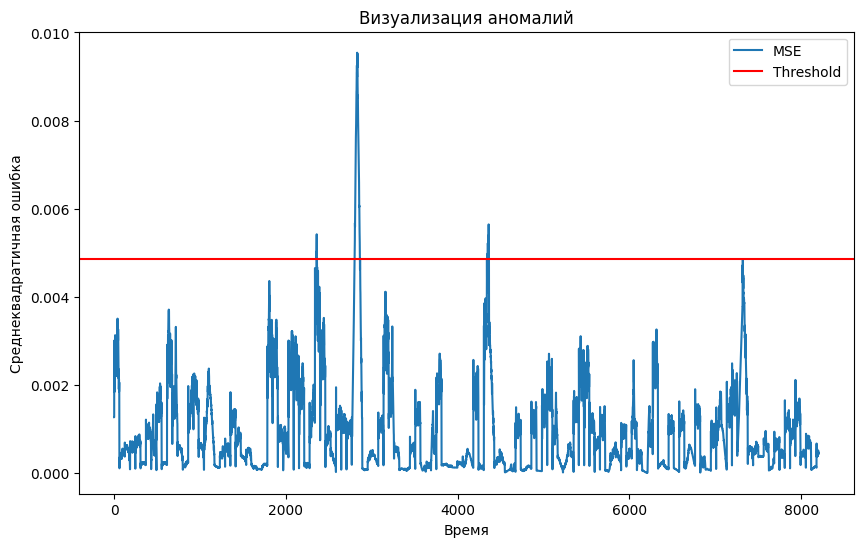

Количество аномалий: 83


In [30]:
import matplotlib.pyplot as plt

# Прогнозируем значения на основе обученного автоэнкодера
predicted = autoencoder.predict(X_train)

# Вычисляем среднеквадратичную ошибку (MSE) между истинными и предсказанными значениями
mse = np.mean(np.power(X_train[:,:,0] - predicted, 2), axis=1)

# Определяем порог для определения аномалий, как 99-й процентиль значений MSE
threshold = np.quantile(mse, 0.99)

# Получаем булев массив, указывающий наличие аномалии в каждой точке данных (True - аномалия, False - не аномалия)
anomalies = mse > threshold

# Визуализация аномалий
plt.figure(figsize=(10, 6))
plt.plot(mse, label='MSE')
plt.axhline(y=threshold, color='r', linestyle='-', label='Threshold')
plt.title('Визуализация аномалий')
plt.xlabel('Время')
plt.ylabel('Среднеквадратичная ошибка')
plt.legend(loc='best')
plt.show()

# Выводим количество аномалий
print(f"Количество аномалий: {np.sum(anomalies)}")


In [31]:
max_float32 = np.finfo(np.float).max
train = np.where(np.isinf(df), max_float32, df)
# Заполнение пропущенных значений
imputer = SimpleImputer(strategy='mean')
df_imputed = pd.DataFrame(imputer.fit_transform(df), columns = df.columns)

# Стандартизация данных
scaler = MinMaxScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df_imputed), columns = df.columns)
dbscan = DBSCAN(eps=0.3, min_samples=5)
predictions = dbscan.fit_predict(df_scaled)

outlier_index = np.where(predictions == -1)
outliers = df_scaled.iloc[outlier_index]



/var/folders/5g/7vyd0lbj2w52qz6789tj57hc0000gn/T/ipykernel_2174/2227946692.py:1: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  max_float32 = np.finfo(np.float).max


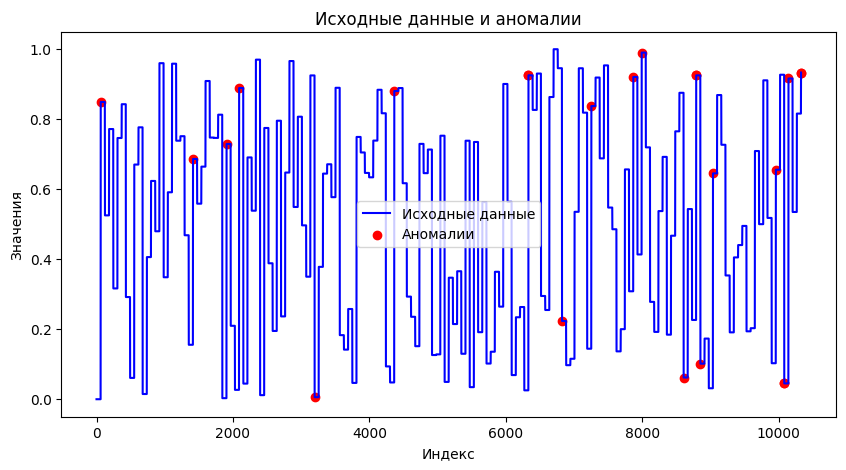

In [32]:
plt.figure(figsize=(10,5))

# Выводим исходные данные на график
plt.plot(df_scaled.index, df_scaled.iloc[:, 0], color='blue', label='Исходные данные')

# Выделяем аномалии на графике
plt.scatter(outliers.index, outliers.iloc[:, 0], color='red', label='Аномалии')

# Задаем название графика
plt.title('Исходные данные и аномалии')

# Обозначаем оси графика
plt.xlabel('Индекс')
plt.ylabel('Значения')

# Выводим легенду
plt.legend(loc='best')

# Отображаем график
plt.show()


In [33]:
from scipy import stats
import numpy as np

z = np.abs(stats.zscore(df))

threshold = 1

outliers = np.where(z > threshold)

print(df.iloc[outliers])


             P_vent  P_technique  P_room_heating     P_pump  P_lightnig  \
time                                                                      
0.0        0.000000     0.000000        0.000000   0.000000         0.0   
0.0        0.000000     0.000000        0.000000   0.000000         0.0   
0.0        0.000000     0.000000        0.000000   0.000000         0.0   
0.0        0.000000     0.000000        0.000000   0.000000         0.0   
0.0        0.000000     0.000000        0.000000   0.000000         0.0   
...             ...          ...             ...        ...         ...   
604800.0  37.176404     9.294101       59.133877  34.852879         0.0   
604800.0  37.176404     9.294101       59.133877  34.852879         0.0   
604800.0  37.176404     9.294101       59.133877  34.852879         0.0   
604800.0  37.176404     9.294101       59.133877  34.852879         0.0   
604800.0  37.176404     9.294101       59.133877  34.852879         0.0   

            P_heating  P

Индексы выбросов:  (array([    0,     1,     2, ..., 10325, 10326, 10327]),)
Выбросы:  [   0.            0.            0.         ... 2168.48122159 2168.48122159
 2168.48122159]


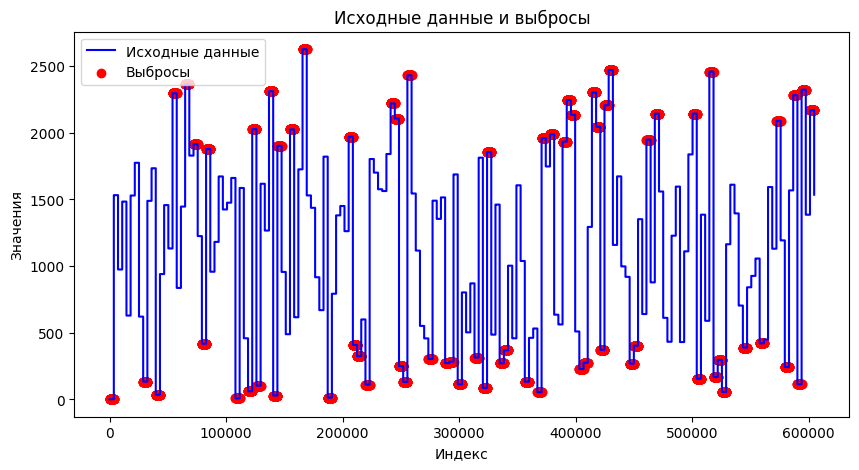

In [34]:
# Выбираем признак, для которой будем искать выбросы
df_feature = df['P_all_power']

# Расчет z-оценок для выбранной фичи
z = np.abs(stats.zscore(df_feature))

# Установка порога для определения выбросов
threshold = 1

# Индексы выбросов в данных
outlier_indices = np.where(z > threshold)

# Получаем значения выбросов
outliers = df_feature.iloc[outlier_indices]

# Выводим индексы и значения выбросов
print("Индексы выбросов: ", outlier_indices)
print("Выбросы: ", outliers.values)

plt.figure(figsize=(10,5))

# Выводим исходные данные на график
plt.plot(df_feature.index, df_feature.values, color='blue', label='Исходные данные')

# Выделяем выбросы на графике
plt.scatter(outliers.index, outliers.values, color='red', label='Выбросы')

# Задаем название графика
plt.title('Исходные данные и выбросы')

# Обозначаем оси графика
plt.xlabel('Индекс')
plt.ylabel('Значения')

# Выводим легенду
plt.legend(loc='best')

# Отображаем график
plt.show()
